# Project 2 Ames Housing
## Step 1:  Variable evaluation

In this step, I employ a modeling approach to determine a set of variables for a housing price model.  The procedure involves several steps in which various variable sets are evaluated using Ordinary Least Squares regression models with the goal of building a streamline, easily understood model.  The core of this approach are two custom-built functions that consider all specified combinations of a set of variables.  These are the model_evaluator and cat_evaluator functions defined in the Define Functions section below.  

The model_evaluator function takes data frames for the X matrix and y vector of a regression, a feature subset to evaluate, parameters for the number of combinations to evaluate and a linear model type. Using these inputs, the function will evaulate all possible combinations (within the min and max) of the features, fit and score the resulting models and output a dataframe which can be evaluated.  The cat_evaluator function takes data frames for the X matrix and y vector of a regression, a list of categorical variables to consider, a baseline feature set, parameters for the number of combinations to evaluate and a linear model type. Using these inputs, the function will evaulate all possible combinations (within the min and max) of the categorical features added to the existing base of numerical variables, fit and score the resulting models and output a dataframe which can be evaluated.

It should be noted that these functions can take a long time to run since they consider all specified combinations.

The steps are

1. Prepare data
    * Read in cleaned housing data
    * Split the training data into training and test subsets
    * Scale the data using Sklearn's standard scaler
    * Separate variables into numeric and categorical
2. Analyze pairwise correlations
    * Determine the 20 variables with the highest correlation with the target variable
3. Use a model evaluator approach to evaluate all variable combinations
    * Consider all model combinations with 5 and 10 variables by using a linear regression
        to generate weights and cross validation to score the model using $R^2$
    * Select the highest scoring model
4. Add categorical variables to the numeric-variable model of step 3
    * Consider all model combinations which combine the numeric variable model of step 3 
        with various categorical variables in the form of dummy variables; consider all dummies 
        associated with a particular categoric as a group when evaluating models
5. Evaluate the model of step 4
    * Use the Stats API linear regression output evaluate both overall model performance and 
        the contribution of individual variables
    * Examine model performance by plotting actual verus predicted housing prices and the residuals 
        of the regression
6. Train the model on the entire training data set and write test-set predictions to a file
    
    
    

## Import libraries

In [1]:
# Imports:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from scipy import stats
import statsmodels.api as sm

import statsmodels.api as sm

from itertools import combinations

%matplotlib inline

# Set the graph style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [2]:
# Set relative data path
data_path = "../datasets"
test_dataframe_name = "test_clean.csv"
train_dataframe_name = "train_clean.csv"
y_trn_dataframe_name = "y_clean.csv"

X1_trn = pd.read_csv(os.path.join(data_path, train_dataframe_name))
X1_tst = pd.read_csv(os.path.join(data_path, test_dataframe_name))
y_trn = pd.read_csv(os.path.join(data_path, y_trn_dataframe_name))

print(X1_trn.shape, X1_tst.shape, y_trn.shape)

(2051, 274) (879, 274) (2051, 1)


In [3]:
# Establish lists of variable types
cat_features = ['ms_subclass', 'ms_zoning', 'util', 'lot_config',
                'neigh', 'bld_type', 'hs_style', 
                'ext_qual', 'ext_cond', 'bsmt_cond', 'heat_qc', 'cen_air',
                'kit_qual', 'funct','garag_type', 'misc_feat','sale_type',
                'street', 'lot_shape','land_cont', 'land_slop', 'cond1', 'cond2',
                'roof_style', 'roof_matl','ext_1st', 'ext_2nd', 'mas_vnr_type', 'found','bsmt_qual',
                'bsmt_exp','bsmt_fin_type_1','bsmt_fin_type_2','heating','electrical',
                'fireplc_qu','garg_fnsh','garg_qlty','garg_cnd','pvd_drive']

num_features = ['lot_area', 'over_qual', 'over_cond',
                'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold', 'mas_vnr_area', 'bsmt_fin_sf',
                'bsmt_fin_sf_2','bsmt_unf_sf','low_qual_fin_sf','kitch_abv_gr','tot_rms_abv_grd',
                'fireplcs','garg_cars', 'garg_area','wood_dck_sf', 'opn_prch_sf',
                '3sn_prch', 'scrn_prch', 'pool_area','misc_val','1st_flr_sf', '2nd_flr_sf',
                'age_home_at_sale','age_remodel_at_sale']


### Split the training data into training and testing subsets

In [4]:
# Split the training data
X1_trn_trn, X1_trn_tst, y_trn_trn, y_trn_tst = train_test_split(X1_trn, y_trn, random_state=223)


### Scale the data


In [5]:
# Use the standard scaler to scale the data
ss = StandardScaler()
ss.fit(X1_trn_trn)
X1_trn_trn_s = pd.DataFrame(ss.transform(X1_trn_trn))
X1_trn_trn_s.columns = X1_trn_trn.columns
X1_trn_tst_s = pd.DataFrame(ss.transform(X1_trn_tst))
X1_trn_tst_s.columns = X1_trn_tst.columns


## Define functions

In [6]:
def correl_plot(df, c_title, figsize, annot=True):
    # Examine correlations of the participation rates and scores
    fig = plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(df.corr()))
    ax = sns.heatmap(df.corr(), 
                     annot = annot,
                     annot_kws = {"size" : 12},
                     mask=mask,
                     cmap = "gist_earth")
    ax.set_title(c_title, fontsize = 14)
    ax.tick_params(axis="x", rotation = 90, labelsize = 12)
    ax.tick_params(axis="y", rotation = 0, labelsize = 12)
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.set_ylim(top=y_max+1)
    ax.set_xlim(right=x_max-1)
    # Credit Douglas Strodtman from the Abalone example

    
def find_most_corr(df, col, ret_n = 5):
    # Get the 
    corrlist=[]
    # For each column in the dataframe get the correlation with col (except col)
    for column in df.columns:
        if col != column:
            corrlist.append({'column' : column,
                             'abs(corr)': abs(np.corrcoef(df[col], df[column])[0][1])})
    # Create a dataframe for sorting
    corr_df = pd.DataFrame(corrlist)
    corr_df = corr_df.sort_values(by = 'abs(corr)', ascending = False)
    # Return the names of the variables
    return list(corr_df['column'][:ret_n])
   
    
# Function to generate and evaluate linear regression models from a set of features
def model_evaluator(X, y, features, min_n, max_n, linear_model = 'lin_regr'):

    # Instantiate the linear regression model
    if linear_model == 'lin_regr':
        lm = LinearRegression()
    elif linear_model == 'lasso':
        lm = LassoCV(n_alphas = 100, cv = 5)
    elif linear_model == 'ridge':
        lm = RidgeCV(alphas=np.linspace(.1, 10, 100), cv = 5)
    else:
        return
    
    # Set up the model list
    model_library = []
    
    # Loop through all combinations starting with 1 variable and ending with number of columns in X
    for i in range(min_n, max_n + 1):
        # Get the i combinations from features
        combos = list(combinations(features, i))
        
        # For each pair create a model, generate predictions, score it and save in a dictionary
        for combo in combos:
            # Get this list of features
            feat_sub = list(combo)
            # Create a new X with a subset of features
            X_sub = X[feat_sub]
            # fit the model and generate predictions
            model = lm.fit(X_sub, y)
            pred = model.predict(X_sub)
            # score the model 
            score_cv = cross_val_score(lm, X_sub, y, cv = 2).mean()
            # save this model in a list of dictionaries 
            model_library.append({
                'Model': linear_model,
                'Combo': list(combo),
                'CV R2': score_cv,
                'Intercept': model.intercept_,
                'Coeff' : model.coef_,
                'Pred' : pred,
            })

    return pd.DataFrame(model_library)


# Function to return a list of variables from the same category variable
def cat_list(df, cat):
    return [x for x in df.columns if cat in x ]
 
    
# Function to evaluate the introduction of a categorical variable against models
def cat_evaluator(X, y, cat_lists, var_combos, min_cat, max_cat, linear_model = 'line_regr'):

    # Instantiate the linear regression model
    if linear_model == 'line_regr':
        lm = LinearRegression()
    elif linear_model == 'lasso':
        lm = LassoCV(n_alphas = 100, cv = 5)
    elif linear_model == 'ridge':
        lm = RidgeCV(alphas=np.linspace(.1, 10, 100), cv = 5)
    else:
        return
    
    # Set up the model list
    model_library = []

    # for each category list in the cat_lists
    # add the category variables (in a list) to each variable combination in var_combos
    for i in range(min_cat, max_cat + 1):
        # Get the combination of cat_lists
        combos = combinations(cat_lists, i)
        for combo in combos:
            cat_list = []
            for category in combo:
                cat_list += category
            for var_combo in var_combos:              
                feat_sub = var_combo[:]
                feat_sub.extend(cat_list)
                # Create a new X with a subset of features
                X_sub = X[feat_sub]
                # fit the model and generate predictions
                model = lm.fit(X_sub, y)
                pred = model.predict(X_sub)
                # score the model 
                score_cv = cross_val_score(lm, X_sub, y, cv = 2).mean()
                # save this model in a list of dictionaries
                model_library.append({
                    'Model': linear_model,
                    'Combo': feat_sub,
                    'CV R2': score_cv,
                    'Intercept': model.intercept_,
                    'Coeff' : model.coef_,
                    'Pred' : pred,
                })

    return pd.DataFrame(model_library)

def write_pred(df, out_file):
    # Open the test file to get the ID
    test_file_name = "test.csv"
    a_tst = pd.read_csv(os.path.join(data_path, test_file_name))
    pred_out = a_tst[['Id']].join(df).sort_values(by='Id')
    # Save the predictions to a csv file
    pred_out.to_csv(os.path.join(data_path, out_file), header = ['Id','SalePrice'], index = False)


def eval_model(y_act, y_pred):
    
    # Make a copy of the y_act dataframe
    df = y_act.copy()
    # Copy y_pred into the data frame
    try:
        df['pred'] = [x[0] for x in y_pred]
    except:
        df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    # create residuals
    df['res'] = df['act'] - df['pred']
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,12))

    fig.suptitle('Model analysis', fontsize = 16)
    
    # Plot the scatter of the predicted versus actual
    ax[0][0] = sns.scatterplot('act','pred', data=df, ax = ax[0][0])
    ax[0][0] = sns.lineplot('act','act', data=df, ax = ax[0][0], color = 'grey')
    ax[0][0].set_title('Predicted versus actuals', fontsize = 14)
    ax[0][0].set_xlabel('Actuals', fontsize = 12)
    ax[0][0].set_ylabel('Predicted', fontsize = 12)
    ax[0][0].text(.25, .75, f"$R^2$ {r2:.4}", horizontalalignment='left',
                  size='large', color='grey', weight='semibold', transform=ax[0][0].transAxes)
    ax[0][0].grid(False)
    
    # Plot the scatter of the residuals versus actuals
    ax[0][1] = sns.scatterplot(x = 'act',y = 'res', data=df, ax = ax[0][1])
    ax[0][1].set_title('Residuals versus actuals', fontsize = 14)
    ax[0][1].set_xlabel('Actuals', fontsize = 12)
    ax[0][1].set_ylabel('Residuals', fontsize = 12)
    ax[0][1].axhline(y=0, color = 'grey')
    ax[0][1].grid(False)
    
    # Plot the residuals
    ax[1][0] = sns.scatterplot(x = df.index,y = 'res', data=df, ax = ax[1][0])
    ax[1][0].set_title('Residuals versus an index', fontsize = 14)
    ax[1][0].set_xlabel('Index', fontsize = 12)
    ax[1][0].set_ylabel('Residuals', fontsize = 12)
    ax[1][0].axhline(y=0, color = 'grey')
    ax[1][0].grid(False)
    
    # Plot the histogram of residuals
    ax[1][1] = sns.distplot( df['res'], ax = ax[1][1])
    ax[1][1].set_title('Histogram of residuals', fontsize = 14)
    ax[1][1].set_xlabel('Residuals', fontsize = 12)
    ax[1][1].set_ylabel('Distribution', fontsize = 12)
    ax[1][1].text(.05,.95, f"p value for $H_0$: residuals are normal {r2:.4}", 
                  horizontalalignment='left', size='large', color='grey', weight='semibold', 
                  transform=ax[1][1].transAxes)
    ax[1][1].grid(False)
    
    # https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
    # https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/
    # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

    
def view_lr_summary(X,y):    
    # Use stats models to generate a summary of the regression
    # Copy the X and y and reset index of y to be equal to x
    X1 = X.copy()
    y1 = y.copy()
    y1.index = X1.index
    X1 = sm.add_constant(X1)
    model = sm.OLS(y1, X1)
    results =  model.fit()
    # return the results
    return results.summary()

def large_scatter(y_act, y_pred):
     # Make a copy of the y_act dataframe
    df = y_act.copy()
    # Copy y_pred into the data frame
    try:
        df['pred'] = [x[0] for x in y_pred]
    except:
        df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    # create residuals
    df['res'] = df['act'] - df['pred']
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16,14))

    # Plot the scatter of the predicted versus actual
    ax = sns.scatterplot('act','pred', data=df, ax = ax, s=200, legend = False)
    ax = sns.lineplot('act','act', data=df, ax = ax, color = 'grey', size=['act'], sizes = [5], legend = False)
    ax.set_title('Predicted versus actuals', fontsize = 40, color = 'grey', weight = 'semibold')
    ax.set_xlabel('Actuals', fontsize = 30, color = 'grey', weight = 'semibold')
    ax.set_ylabel('Predicted', fontsize = 30, color = 'grey',weight = 'semibold')
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.text(.25, .75, f"$R^2$ {r2:.4}", horizontalalignment='left', fontsize = 40,
                  color='grey', weight='semibold', transform=ax.transAxes)
    ax.grid(False)


## Model preparation

### View correlations

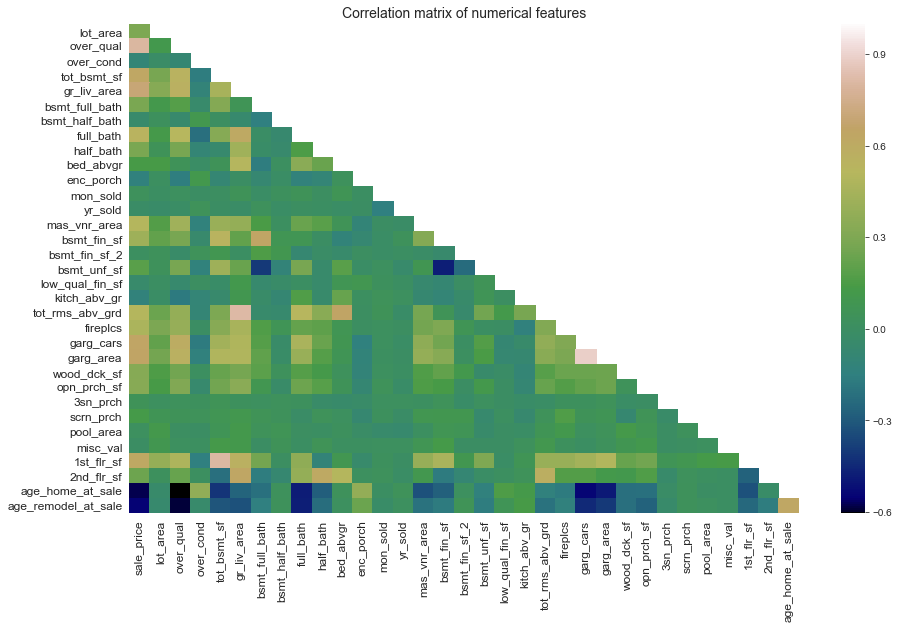

In [7]:
# View a correlation matrix of the 
df = y_trn.join(X1_trn[num_features])
c_title = "Correlation matrix of numerical features"
correl_plot(df, c_title, (15,9), False)

### View pairplots

In [8]:
# View 
# sns.pairplot(df)

## Numeric feature modeling


###  Use model_evaluator

Use the model_evaluator function to generate and score models of all combinations of numeric variables.  The output is stored in a dataframe.

The logic is to select the most correlated variables and to use those to evaluate models of various sizes.  The model evaluator function considers all combinations of the specified size models and uses OLS to fit and score the models.  The scoring tool employs cross_val_score.

In [21]:
# find the variables with highest correlation
df = y_trn.join(X1_trn[num_features])
var = find_most_corr(df, 'sale_price', ret_n = 20)


In [22]:
# Evaluate all the model combinations of num_features 
# Store in a dataframe for evaluation
# Create a dataframe of linear regression models
lr_nums=[]
for i in [5, 10, 15]:
    lr_num_models = model_evaluator(X1_trn_trn_s, y_trn_trn, var, i, i, linear_model = 'lin_regr')
    lr_nums.append(lr_num_models)
    print("Finished: ", i)
    

Finished:  5
Finished:  10
Finished:  15


In [23]:
# view the top models 
lr_nums[1].sort_values(by='CV R2', ascending = False).head()

,CV R2,Coeff,Combo,Intercept,Model,Pred
16232,0.820770,"[[30265.684556066833, 28925.233443399935, 8817...","[over_qual, gr_liv_area, garg_area, age_home_a...",[182079.46879063718],lin_regr,"[[7137.790455089387], [202519.18014836757], [1..."
16707,0.820705,"[[30309.049367446427, 26235.142168498238, 8953...","[over_qual, gr_liv_area, garg_area, age_home_a...",[182079.46879063718],lin_regr,"[[7497.7006689184345], [202385.3066307069], [1..."
16688,0.820566,"[[30383.147311903733, 26125.829700215145, 8983...","[over_qual, gr_liv_area, garg_area, age_home_a...",[182079.46879063718],lin_regr,"[[9510.040108628455], [203433.10431581794], [1..."
5386,0.820175,"[[30348.049158139256, 25993.5118884459, 9239.8...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[182079.46879063718],lin_regr,"[[9515.973449426412], [203078.84768925823], [1..."
16442,0.820079,"[[30227.454465963823, 27626.951914654208, 8960...","[over_qual, gr_liv_area, garg_area, age_home_a...",[182079.46879063718],lin_regr,"[[9827.91519980834], [203019.43486806375], [19..."


In [24]:
# join the two model dataframes into one
lr_num_models = pd.concat(lr_nums)


In [25]:
# Show the models considered
lr_num_models.shape


(215764, 6)

In [26]:
# Store the variable combinations for the top models in a list
lr_top_num_models = list(lr_num_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:1])


## Add in categorical variables

The cat_evaluator takes the out of the model evaluation and adds in categorical variables.  It does so, by grouping all dummies associated with one category into a list.  It then adds this list to the existing variable base and scores the model, again using cross-value score.  It evaluates all possible combinations of these models between the specified minimum and maximum and returns the results in a dataframe.


In [27]:
# For each category feature create a list of related columns
# cat_lists is a list of lists 
cat_lists = [ cat_list(X1_trn, cat) for cat in cat_features]


In [ ]:
# Add the category variables 
# Evaluate adding the category variables to the existing linear regression sets
lr_num_cat_models = cat_evaluator(X1_trn_trn_s, y_trn_trn, cat_lists, lr_top_num_models, 1, 5, linear_model = 'line_regr')


In [27]:
# Look at the size of this data frame
lr_num_cat_models.shape


(10700, 6)

In [28]:
# Look at the top models with categorical variables
lr_num_cat_models.sort_values(by ='CV R2', ascending = False).head()

,CV R2,Coeff,Combo,Intercept,Model,Pred
3566,0.862405,"[[18528.719421524063, 19552.701606777726, 4144...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[182079.46879063718],line_regr,"[[39929.11521356559], [195773.0965395067], [19..."
3561,0.858747,"[[17872.28352995729, 21260.98768583974, 3666.4...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[182079.46879063718],line_regr,"[[39096.51724727475], [198288.2410837668], [19..."
3794,0.858389,"[[16266.42267981304, 21430.963611959294, 7150....","[over_qual, gr_liv_area, garg_area, garg_cars,...",[182079.46879063718],line_regr,"[[37712.4184446265], [194271.0627951592], [194..."
3793,0.855664,"[[16406.25708717729, 20555.554838363794, 7154....","[over_qual, gr_liv_area, garg_area, garg_cars,...",[182079.46879063718],line_regr,"[[39072.05543860275], [192924.82666183144], [1..."
3777,0.855061,"[[17190.397292465506, 21625.401226672147, 6673...","[over_qual, gr_liv_area, garg_area, garg_cars,...",[182079.46879063718],line_regr,"[[38096.926057726785], [193467.5800207042], [1..."


### Pick the top performing model on the training subset of the training data

In [29]:
# Store the variable combinations for the top models in a list
lr_top_models = list(lr_num_cat_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:15])

lr_best_model = list(lr_num_cat_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:1])


In [30]:
# Get the training R2 for this model
R2 = lr_num_cat_models.sort_values(by = 'CV R2', ascending = False)['CV R2'][:1]
print("Linear regression: R2", R2)


Linear regression: R2 3566    0.862405
Name: CV R2, dtype: float64


## Test the model on training test set

In [31]:
# Examine teh top linear regression model from above
lr = LinearRegression()
model_lr = lr.fit(X1_trn_trn_s[lr_best_model[0]], y_trn_trn)
pred_lr_trn_tst = lr.predict(X1_trn_tst_s[lr_best_model[0]])

r2_score(y_trn_tst, pred_lr_trn_tst)

0.8096976276112664

## Evaluate the model

### Use the statsmodels api to see a summary of the regression

In [33]:
# Uses stats models to view the lr summary results
results = view_lr_summary(X1_trn_trn_s[lr_best_model[0]], y_trn_trn)
results


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     261.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        06:18:38   Log-Likelihood:                -17850.
No. Observations:                1538   AIC:                         3.579e+04
Df Residuals:                    1493   BIC:                         3.603e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.821e+05    687.275    264.929      0.000    1.81e+05    1.83e+05
over_qual            1.853e+04   1280.330     14.472      0.000     1.6e+04     2.1e+04
gr_liv_area          1.955e+04   1113.983     17.552      0.000    1.74e+04    2.17e+04
garg_area            4144.6363   1665.037      2.489      0.013     878.577    7410.696
garg_cars            2649.5426   1710.668      1.549      0.122    -706.026    6005.112
1st_flr_sf           5442.8968   1023.690      5.317      0.000    3434.874    7450.920
age_home_at_sale    -7719.6226   1614.695     -4.781      0.000   -1.09e+04   -4552.311
age_remodel_at_sale -5468.4829   1060.859     -5.155      0.000   -7549.415   -3387.551
fireplcs             3973.9004    881.504      4.508      0.000    2244.782    5703.018
bsmt_fin_sf          1.017e+04    816.200     12.464      0.000    8571.980    1.18e+04
opn_prch_sf          -134.2871    777.432     -0.173      0.863   -1659.262    1390.688
neigh_Blueste        -233.5038    776.916     -0.301      0.764   -1757.466    1290.459
neigh_BrDale         -603.9552   1081.522     -0.558      0.577   -2725.419    1517.509
neigh_BrkSide       -4485.6911   1666.121     -2.692      0.007   -7753.878   -1217.505
neigh_ClearCr         -41.0403   1067.501     -0.038      0.969   -2135.002    2052.921
neigh_CollgCr       -5805.0594   2115.951     -2.743      0.006   -9955.611   -1654.508
neigh_Crawfor        -692.9433   1547.411     -0.448      0.654   -3728.273    2342.386
neigh_Edwards       -7232.8297   2027.754     -3.567      0.000   -1.12e+04   -3255.280
neigh_Gilbert       -5562.1249   1784.688     -3.117      0.002   -9062.888   -2061.362
neigh_Greens         -324.1252    735.333     -0.441      0.659   -1766.522    1118.271
neigh_GrnHill        3581.4291    727.978      4.920      0.000    2153.460    5009.398
neigh_IDOTRR        -5155.4065   1606.773     -3.209      0.001   -8307.178   -2003.635
neigh_Landmrk        -144.1751    720.458     -0.200      0.841   -1557.392    1269.042
neigh_MeadowV        -288.7688   1101.437     -0.262      0.793   -2449.298    1871.760
neigh_Mitchel       -4264.8041   1561.730     -2.731      0.006   -7328.222   -1201.387
neigh_NAmes         -8613.3680   2725.397     -3.160      0.002    -1.4e+04   -3267.354
neigh_NPkVill        -297.9723    919.966     -0.324      0.746   -2102.536    1506.591
neigh_NWAmes        -5483.3724   1583.851     -3.462      0.001   -8590.181   -2376.564
neigh_NoRidge        3107.6462   1283.535      2.421      0.016     589.923    5625.370
neigh_NridgHt        5629.6691   1768.007      3.184      0.001    2161.628    9097.710
neigh_OldTown       -7758.5613   2240.211     -3.463      0.001   -1.22e+04   -3364.266
neigh_SWISU         -3707.5033   1205.439     -3.076      0.002   -6072.037   -1342.969
nei

### Look for multicollinearity

From the above results, it is clear that this model suffers for multicollinearity issues and that the coefficients and predictions may not be valid when applied to new data sets.


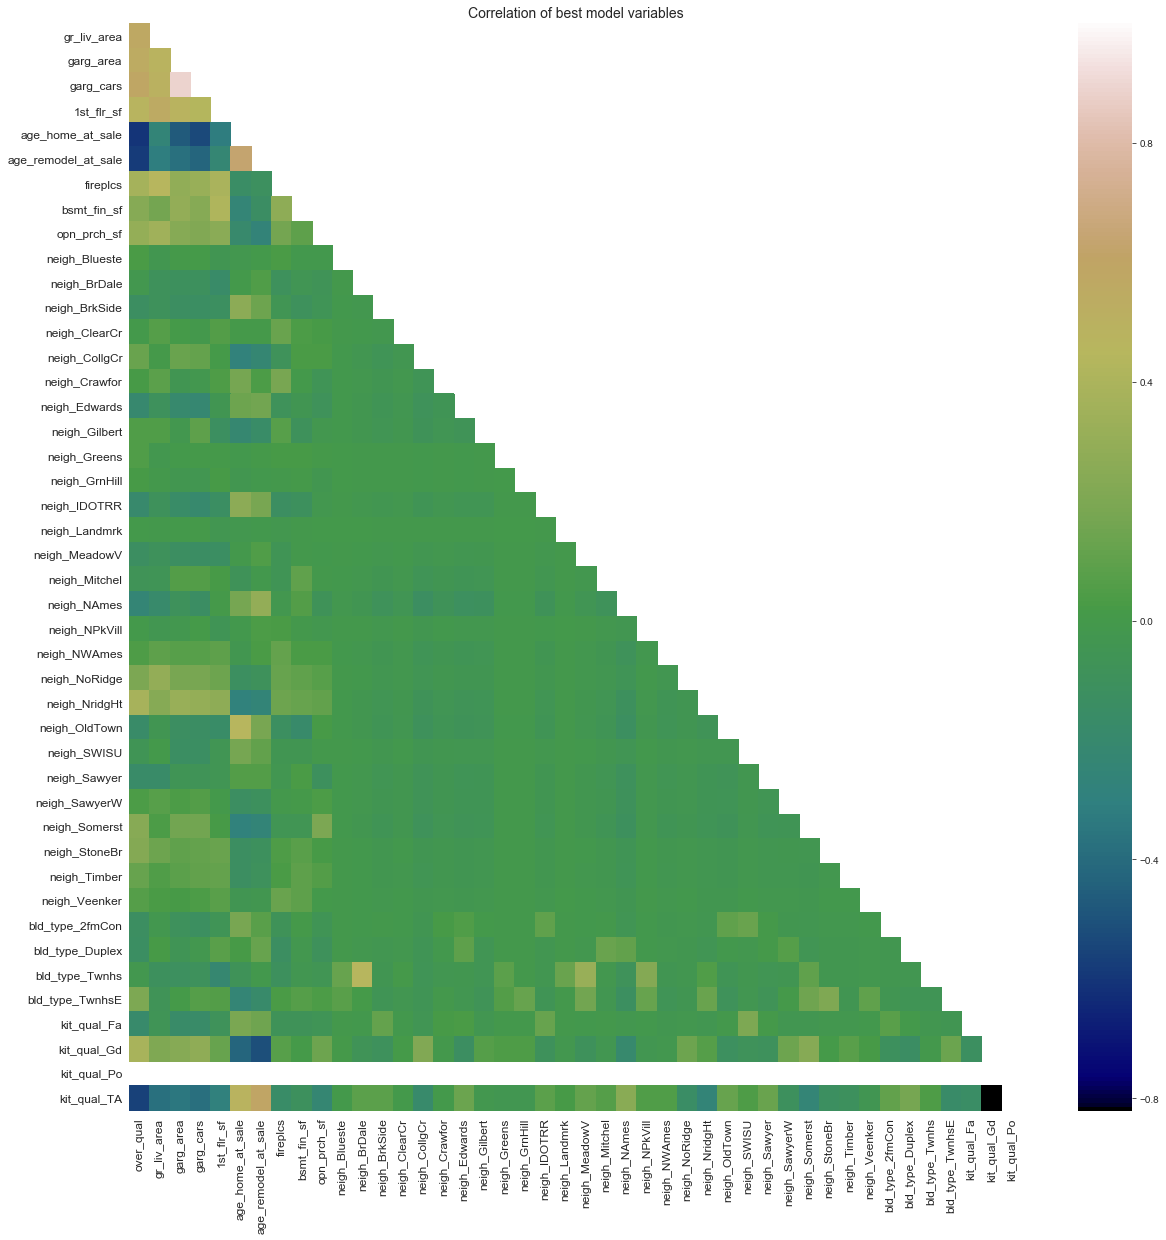

In [34]:
# draw correlation matrix to look for multi-collineaerity
correl_plot(X1_trn_trn_s[lr_best_model[0]], 'Correlation of best model variables', (20,20), annot=False)

### Use the eval_model function to examine predictions and residuals

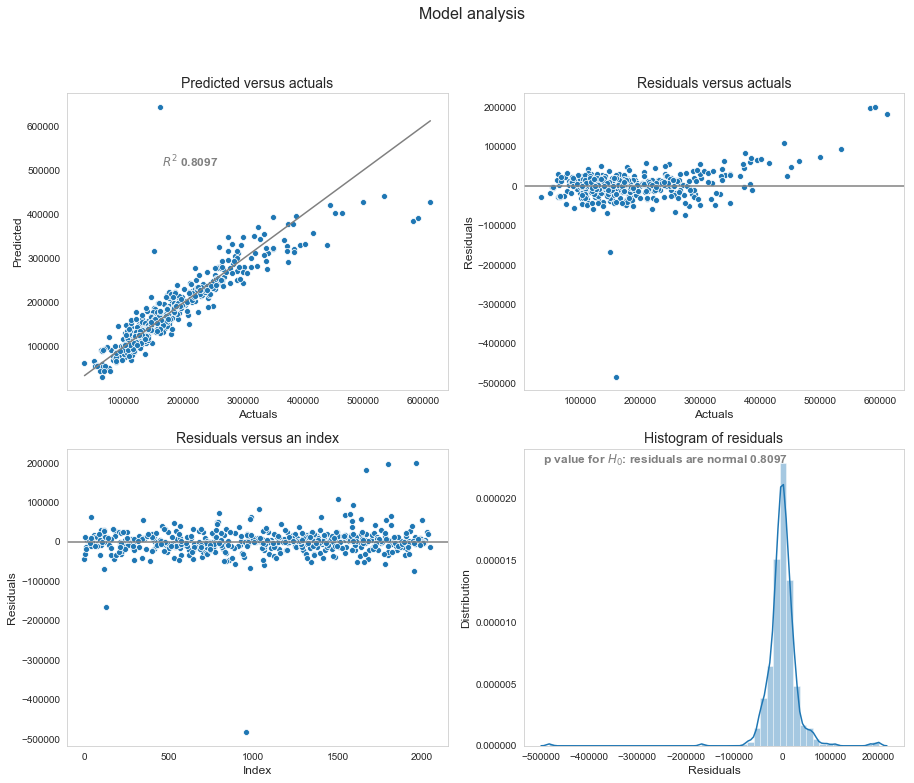

In [35]:
# Look at various plots of the residuals
eval_model(y_trn_tst, pred_lr_trn_tst)


In [37]:
# Print the columns
print(lr_best_model[0])


['over_qual', 'gr_liv_area', 'garg_area', 'garg_cars', '1st_flr_sf', 'age_home_at_sale', 'age_remodel_at_sale', 'fireplcs', 'bsmt_fin_sf', 'opn_prch_sf', 'neigh_Blueste', 'neigh_BrDale', 'neigh_BrkSide', 'neigh_ClearCr', 'neigh_CollgCr', 'neigh_Crawfor', 'neigh_Edwards', 'neigh_Gilbert', 'neigh_Greens', 'neigh_GrnHill', 'neigh_IDOTRR', 'neigh_Landmrk', 'neigh_MeadowV', 'neigh_Mitchel', 'neigh_NAmes', 'neigh_NPkVill', 'neigh_NWAmes', 'neigh_NoRidge', 'neigh_NridgHt', 'neigh_OldTown', 'neigh_SWISU', 'neigh_Sawyer', 'neigh_SawyerW', 'neigh_Somerst', 'neigh_StoneBr', 'neigh_Timber', 'neigh_Veenker', 'bld_type_2fmCon', 'bld_type_Duplex', 'bld_type_Twnhs', 'bld_type_TwnhsE', 'kit_qual_Fa', 'kit_qual_Gd', 'kit_qual_Po', 'kit_qual_TA']


###  Create a large scatter for the presentation

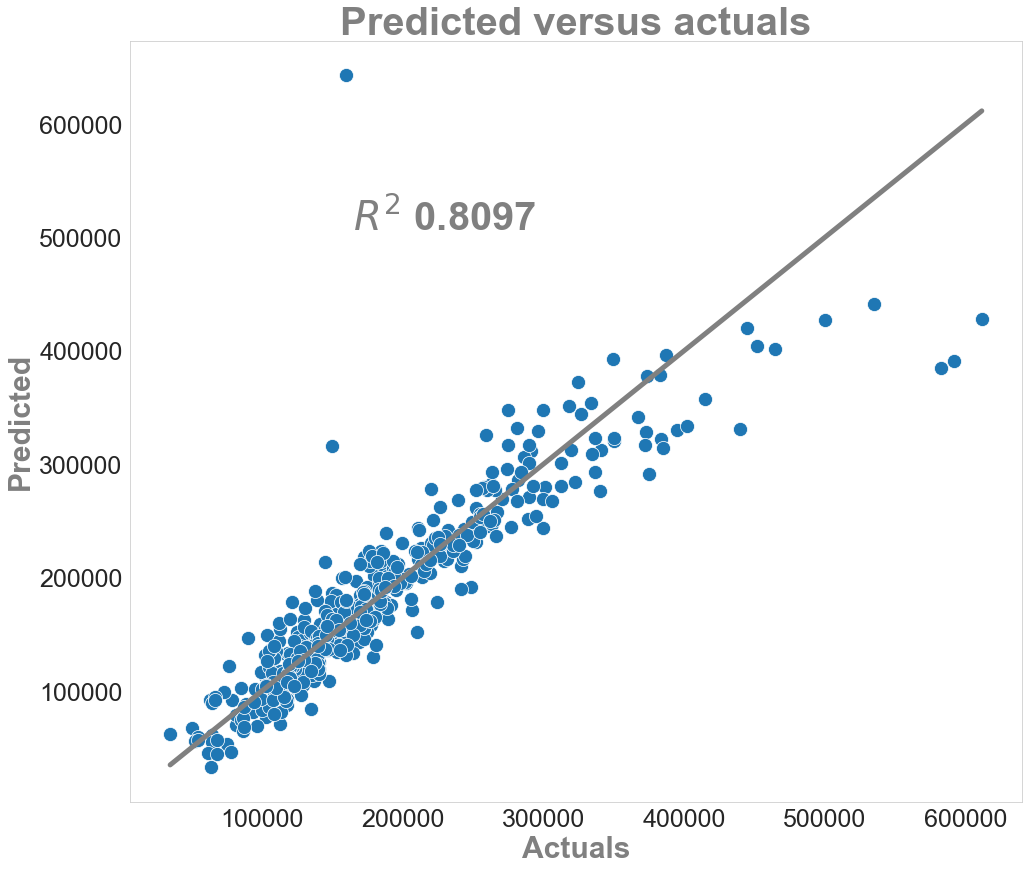

In [44]:
# Large scatter plot for presentation
large_scatter(y_trn_tst, pred_lr_trn_tst)


### Train the model on the entire training data set


In [38]:
# Update the scalar to include all of the data in the training set
ss = StandardScaler()
ss.fit(X1_trn)
X1_trn_s = pd.DataFrame(ss.transform(X1_trn))
X1_trn_s.columns = X1_trn.columns
X1_tst_s = pd.DataFrame(ss.transform(X1_tst))
X1_tst_s.columns = X1_tst.columns


In [39]:
# Update the linear regression model to the full training set
lr = LinearRegression()
model_lr = lr.fit(X1_trn_s[lr_best_model[0]], y_trn)
pred_lr_trn = lr.predict(X1_trn_s[lr_best_model[0]])
r2_score(y_trn, pred_lr_trn)


0.8667722872060886

### Create predictions on the test data set

In [40]:
# Create test predictions
pred_lr_tst = pd.DataFrame(lr.predict(X1_tst_s[lr_best_model[0]]))
                           

### Write to a file 


In [41]:
# write the test set predictions to a file
write_pred(pd.DataFrame(pred_lr_tst),"pred_1f_Steve_Godfrey.csv" )

